<a href="https://colab.research.google.com/github/savindumahasen/Chatbot/blob/main/chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot with Lang-graph

In [33]:
!pip install langgraph langsmith
!pip install langchain langchain_groq langchain_community

In [34]:
## Use Groq and Lang smith API keys
from google.colab import userdata
groq_api_key=userdata.get('GROQ_API_KEY')
langsmith_api_key=userdata.get("LANG_SMITH_API_KEY")

In [35]:
## setup the  langsmith APi key
import os
os.environ["LANGCHAIN_API_KEY"]=langsmith_api_key
os.environ["LANCHAIN_TRACING_V2"]="true"
os.environ["LANCHAIN_PROJECT"]="chatbot"

In [36]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7ba6d7b31090>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7ba6d7b31bd0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Building the chatbot using Langgraph

In [37]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [38]:
## Build the graph

class State(TypedDict):
  ## Messages have type "list". The add_messages function
  ## In the annotation defines how  this state key should be updated
  ## in this case, append messages to the list rather than overwriting it
  messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [39]:
graph_builder

In [40]:
def chatbot(state:State):
  return {"messages":llm.invoke(state['messages'])}

In [41]:
graph_builder.add_node("chatbot", chatbot)
graph_builder

In [42]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot",END)

In [43]:
## compile the graph builder
graph=graph_builder.compile()

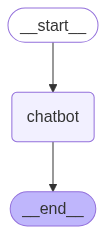

In [44]:
## display the graph

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
## Test the bot with some user queries

In [ ]:
while True:
  user_input=input("User ")
  if user_input.lower() in ["quit","q"]:
    print("Good Buy")
    break
  for event in graph.stream({'messages':("user",user_input)}):
    #print(event.values())
    for value in event.values():
      #print(value['messages'])
      print("Assistant:",value['messages'].content)

User Hi,
Assistant: Hi! 👋  

How can I help you today? 😊

User Hi I am Savindu
Assistant: Hello Savindu! 👋

It's nice to meet you. 😊

What can I do for you today?

